## Data

Спочатку завантажуємо word embeddings для української мови.

In [1]:
!curl http://lang.org.ua/static/downloads/models/news.lowercased.tokenized.word2vec.300d.bz2 --output news.lowercased.tokenized.word2vec.300d.bz2

In [2]:
!bunzip2 news.lowercased.tokenized.word2vec.300d.bz2

In [1]:
from gensim.models import KeyedVectors

%time wv = KeyedVectors.load_word2vec_format('news.lowercased.tokenized.word2vec.300d', binary=False)

CPU times: user 56.3 s, sys: 517 ms, total: 56.8 s
Wall time: 56.6 s


In [3]:
wv.most_similar('слово')

[('дієслово', 0.6502863764762878),
 ('слівце', 0.6484909653663635),
 ('словосполучення', 0.6456568241119385),
 ('гасло', 0.5913079977035522),
 ('слово**', 0.555127739906311),
 ("прислів'я", 0.5407627820968628),
 ('письмо', 0.5235773324966431),
 ('прізвище', 0.52119380235672),
 ('пророцтво', 0.5125285983085632),
 ('ремесло', 0.5058826804161072)]

Потім розпаковуємо та завантажуємо дані.

In [ ]:
!unzip -q ../../../tasks/1551.zip

replace 1551/Інші-Подяки.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
!ls 1551 | head -n 15

Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою.txt
Бажаючі-отримати--Картки-киянина--КК--.txt
Будівництво-АЗС.txt
Будівництво-в-нічний-час.txt
Будівництво-дооблаштування-дитячого-майданчику.txt
Будівництво--дооблаштування-спортивних-майданчиків.txt
Будівництво-та-реконструкція-об-єктів-освіти.txt
Взаємовідносини-з-сусідами.txt
Вивезення--утилізація-твердих-та-негабаритних-відходів.txt
Видалення-аварійних--пошкоджених-хворобами-дерев.txt
Видача-розрахункових-книжок--квитанцій--довідок.txt
Вилов-безпритульних-тварин.txt
Вирізування--кронування--гілля-дерев.txt
Виток-холодної-води-на-поверхню.txt
Відновлення-благоустрою-після-вик--планових-аварійних-робіт-на-об-єктах-благоуст.txt
ls: write error: Broken pipe


In [2]:
import glob

files = glob.glob("1551/*")

files[:10]

['1551/Незадовільна-температура-ГВП.txt',
 '1551/Незадовільне-обслуговування-в-амбулаторно-поліклінічних-установах.txt',
 '1551/Відсутнє-електропостачання.txt',
 '1551/Порушення-правил-тиші--після-------.txt',
 '1551/Неякісне-ХВП.txt',
 '1551/Нанесення-дорожньої-розмітки.txt',
 '1551/Робота-циркуляційної-системи.txt',
 '1551/Встановлення-світлофора.txt',
 '1551/Завезення-піску-на-дитячий-майданчик.txt',
 '1551/Скошування-трави.txt']

In [7]:
import os
from collections import namedtuple

Document = namedtuple('Document', 'id topic_id tags content')

def parse_tags(file):
    return [tag for tag in os.path.basename(file.name)[:-4].split('-') if tag]

def parse_topic_file(topic_id, filename):
    documents = []    
    with open(filename) as f:
        tags = parse_tags(f)        
        _id = None
        idx = -1        
        for line in f:            
            if line.strip().isnumeric():
                _id = int(line.strip())
                documents.append(Document(_id, topic_id, tags, []))
                idx +=1
                continue
            if not (_id is None) and line.strip():                
                documents[idx].content.append(line.strip())                
    
    return [doc._replace(content = ''.join(doc.content)) for doc in documents]

In [8]:
all_documents = [doc for topic_id, file in enumerate(files) \
                 for doc in parse_topic_file(topic_id, file) if len(doc.content) > 0]

len(all_documents)

114348

In [9]:
all_documents[:3]

[Document(id=2697865, topic_id=0, tags=['Незадовільна', 'температура', 'ГВП'], content='Недогрев горячей воды (вода нормальной температуры подавалась неделю с15 по 23, до этого была частичная подача горячей воды (пару часов вечером и ночью горячая), остальное время теплой), сейчас опять температура порядка 40 градусов. Эта ситуация продолжается на фоне постоянного недогрева батарей в квартире, ДУ 12 ККЕУ  МОУкраины  не реагирует на ситуацию.'),
 Document(id=3170827, topic_id=0, tags=['Незадовільна', 'температура', 'ГВП'], content='Из горячего крана течет холодная вода, в вечернее и утреннее время купаться нет возможности. Необходимо или пересчитывать тарифы или включать горячую воду.'),
 Document(id=3165270, topic_id=0, tags=['Незадовільна', 'температура', 'ГВП'], content='Я поживаю на 6 этаже 9и - этажного дома на протяжении долгого промежутка времени у нас в квартире из крана горячей воды, особенно утром и в первой половине дня течёт если не холодная вода, то вода чуть тёплая. По утр

Тепер фільтруємо документи з українською мовою.

In [10]:
from langdetect import detect
from langdetect.detector import LangDetectException
from tqdm import tqdm_notebook
import os
import pickle

def memoize(filename, compute):  
    
    fullname = filename + '.can'
    
    if os.path.isfile(fullname):
        with open(fullname, 'rb') as f:                        
            return pickle.load(f)
    
    result = compute()
    with open(fullname, 'wb') as f:
        pickle.dump(result, f)
    
    return result

def is_uk(text):
    
    if len(text):
        try:
            return detect(text[:1024]) == 'uk'
        except LangDetectException as e:
            return False
    
    return False

uk_documents = memoize('uk_documents', 
                       lambda: [doc for doc in tqdm_notebook(all_documents) if is_uk(doc.content)])

Дивимся на дані.

In [11]:
import pandas

uk_doc_df = pandas.DataFrame([doc._replace(tags = "-".join(doc.tags)) for doc in uk_documents])

In [172]:
uk_doc_df.head(10)

,id,topic_id,tags,content
0,3152784,0,Незадовільна-температура-ГВП,Відсутнітність горячого водопостачання належно...
1,3143050,0,Незадовільна-температура-ГВП,Добрий вечір.Прошу розібратися з проблемою нев...
2,3142427,0,Незадовільна-температура-ГВП,На моє звернення № Г-6623 відповідь написав ди...
3,3130991,0,Незадовільна-температура-ГВП,Доброго дня! Вже більше двох тижнів гаряче вод...
4,2405990,0,Незадовільна-температура-ГВП,На звернення:Номер звернення:\tГ-6478Зареєстро...
5,3115494,0,Незадовільна-температура-ГВП,"Звертаюсь до Вас стосовно вирішення питання, щ..."
6,3104107,0,Незадовільна-температура-ГВП,Доброго дня!!! Моє звернення від 02.12.14 #Г-1...
7,3091571,0,Незадовільна-температура-ГВП,Протягом останнього тижня гаряча вода недостат...
8,2690156,0,Незадовільна-температура-ГВП,Прошу прийняти необхідні заходи по покращенню ...
9,2748419,0,Незадовільна-температура-ГВП,немає температури гарячої води


In [173]:
uk_doc_df.describe(include='all')

,id,topic_id,tags,content
count,6.182900e+04,61829.000000,61829,61829
unique,NaN,NaN,188,56061
top,NaN,NaN,Відсутність-ГВП,Відсутнє гаряче водопостачання
freq,NaN,NaN,6564,46
mean,3.159625e+06,105.551731,NaN,NaN
std,1.084360e+07,55.922291,NaN,NaN
min,1.000000e+01,0.000000,NaN,NaN
25%,2.841555e+06,58.000000,NaN,NaN
50%,3.083712e+06,121.000000,NaN,NaN
75%,3.245460e+06,150.000000,NaN,NaN


In [174]:
uk_doc_df.groupby(['topic_id', 'tags']).count().sort_values(['id'], ascending = False).head(50)

,,id,content
topic_id,tags,,
138,Відсутність-ГВП,6564,6564
180,Укладання-та-ремонт-асфальтного-покриття,3628,3628
27,Відсутність-опалення,3142,3142
127,Перевірка-дозвільної-документації-демонтаж-кіосків-ларків,2199,2199
67,Прибирання-та-санітарний-стан-територій,2005,2005
79,Технічний-стан-проїжджих-частин-вулиць-та-тротуарів,1303,1303
155,Відновлення-благоустрою-після-вик-планових-аварійних-робіт-на-об-єктах-благоуст,1289,1289
121,Відсутність-освітлення-у-під-їзді-за-відсутності-несправності-лампочок,1256,1256
58,Не-працює-пасажирський-ліфт,1220,1220


Виділяємо лейбли.

In [12]:
import numpy as np

topic_labels = np.array([doc.topic_id for doc in uk_documents])
len(topic_labels)

61818

І розбиваємо дані на тренувальні і тестові.

In [13]:
from sklearn.model_selection import train_test_split

train_documents, test_documents, train_topic_labels, test_topic_labels = \
    train_test_split(uk_documents, topic_labels, random_state = 26, test_size = 0.3, stratify = topic_labels)

In [14]:
print(len(train_documents))
print(len(train_topic_labels))

43272
43272


In [15]:
print(len(test_documents))
print(len(test_topic_labels))

18546
18546


## Baseline

Будуємо бейзлайн, знаходимо суму векторів слів по кожному документу і використовуємо kNN на знайденних векторах. Для порівняння векторів застосовуємо cosine similarity. Перед знаходженням суми векторів, документ токенізується та видаляються stop words. Знайдені вектори нормалізуються, в такому випадку eclidean distance для kNN має той самий ефект що й cosine distance, при цьому алгоритм дозволяє використовувати більш ефективні структури данних, такі як, наприклад, k-d tree.

In [16]:
import tokenize_uk
import string
import html
import re

with open('uk_stop_words.txt') as f:
    STOP_WORDS = f.read().split()
    
EXT_PUNCTUATION = "”...«»№"

def contain_numbers(s):
    return bool(re.search(r'\d', s))

def non_stop_word(word):
    return not (word in string.punctuation or word in EXT_PUNCTUATION \
                or word in STOP_WORDS or contain_numbers(word) or len(word) < 2)

def remove_stop_words(tokens):
    return [token for token in tokens if non_stop_word(token.lower())]

def tokenize_doc(doc):
    return [word.lower() for word in \
            remove_stop_words(tokenize_uk.tokenize_words(html.unescape(doc.content)))]

def normalize_vec(x):
    m = np.max(x)
    if m > 0.0:
        return x/np.sqrt(np.dot(x,x))
    return x
    
def doc_to_sum_vec(doc):
    words = tokenize_doc(doc)    
    vec = np.zeros(300)
    for word in words:
        try:
            vec += wv[word]
        except KeyError as e:            
            pass
        
    return vec

Рахуємо вектори для тренувальних і тестових документів.

In [17]:
train_doc_sum_vecs = np.array([doc_to_sum_vec(doc) for doc in tqdm_notebook(train_documents)])

In [18]:
test_doc_sum_vecs = np.array([doc_to_sum_vec(doc) for doc in tqdm_notebook(test_documents)]) 

### kNN+sum vectors

Тренуємо модель.

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

class Model:
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels):
        self.train_vectors = train_vectors
        self.train_labels = train_labels
        self.test_vectors = test_vectors
        self.test_labels = test_labels
        
    def train(self):
        self.model.fit(self.train_vectors, self.train_labels)
        self.topics_predicted = self.model.predict(self.test_vectors)
        
    def test(self):
        self.test_report = classification_report(self.test_labels, self.topics_predicted)
        print(classification_report(self.test_labels, self.topics_predicted))  

class KnnModel(Model):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels, n = 1):
        super().__init__(np.array([normalize_vec(doc) for doc in train_vectors]),\
                       train_labels,\
                       np.array([normalize_vec(doc) for doc in test_vectors]),\
                       test_labels)                
        self.model = KNeighborsClassifier(n_neighbors = n, algorithm='kd_tree', metric = 'euclidean', n_jobs = 6)    

In [15]:
knn = KnnModel(train_doc_sum_vecs, train_topic_labels, test_doc_sum_vecs, test_topic_labels)

In [16]:
%time knn.train()

CPU times: user 11min 14s, sys: 282 ms, total: 11min 15s
Wall time: 1min 57s


In [17]:
knn.test()

              precision    recall  f1-score   support

           0       0.46      0.55      0.50       335
           1       0.77      0.80      0.79        41
           2       0.55      0.30      0.39        79
           3       0.38      0.28      0.32        39
           4       0.88      0.32      0.47        22
           5       0.42      0.30      0.35       106
           6       0.22      0.32      0.26       142
           7       0.25      0.32      0.28        62
           8       0.81      0.43      0.57        30
           9       0.40      0.36      0.38        22
          10       0.57      0.53      0.55       144
          11       0.21      0.17      0.19        29
          12       0.44      0.36      0.40        22
          13       0.33      0.31      0.32        45
          14       0.23      0.18      0.20        84
          15       0.40      0.25      0.31        16
          16       0.51      0.48      0.49       122
          17       0.25    

## Imrovements

Намагаємося покращити результат. Спочатку будемо використовувати логістичну регресію, потім проробимо все те саме але з векторами Doc2Vec.

### Logreg+sum vectors

In [79]:
from sklearn.linear_model import LogisticRegression

class LogregModel(Model):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels, iters = 3000):
        super().__init__(train_vectors, train_labels, test_vectors, test_labels)
        self.model = LogisticRegression(random_state=26, n_jobs = 6, solver="lbfgs", \
                                        multi_class="multinomial", max_iter = iters)

In [80]:
logreg = LogregModel(train_doc_sum_vecs, train_topic_labels, test_doc_sum_vecs, test_topic_labels)

In [81]:
%time logreg.train()

CPU times: user 407 ms, sys: 308 ms, total: 715 ms
Wall time: 27min 32s


In [82]:
logreg.test()

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        28
           1       0.34      0.20      0.25        87
           2       0.47      0.52      0.49        83
           3       0.71      0.62      0.67        40
           4       0.44      0.37      0.40       185
           5       0.43      0.48      0.45        25
           6       0.62      0.64      0.63        50
           7       0.22      0.30      0.25        44
           8       0.29      0.27      0.28        22
           9       0.85      0.77      0.81        22
          10       0.06      0.08      0.07        25
          11       0.64      0.45      0.53        20
          12       0.51      0.64      0.57        53
          13       0.19      0.31      0.24        16
          14       0.18      0.25      0.21        24
          15       0.44      0.37      0.40        19
          16       0.46      0.49      0.48       137
          17       0.18    

Є невелике покращення в якості.

### kNN+Doc2Vec

Переходимо до Doc2Vec. Для цього використовуємо gensim. Спочатку конвертуємо наші документи в модель gensim.

In [19]:
from gensim.models.doc2vec import TaggedDocument

def to_tagged_doc(doc):
    words = tokenize_doc(doc)
    return TaggedDocument(words, [doc.topic_id])

In [20]:
to_tagged_doc(uk_documents[15])

TaggedDocument(words=['заявляю', 'чергове', 'втручання', 'діяльність', 'інформаційної', 'системи', 'колцентру', 'метою', 'викривлення', 'відомостей', 'стосовно', 'результатів', 'вирішення', 'поданих', 'звернень', 'даний', 'відмітку', 'виконано', 'наводжу', 'витяг', 'березня', 'перегляд', 'інтерактивній', 'картівідсутність', 'гвп', 'відповідальний', 'кп', 'печерська', 'брама', 'мазурчак', 'олександр', 'володимирович', 'дата', 'контролю', 'березня', 'статус', 'виконано', 'відповідаю', 'дійсності', 'оскільки', 'годин', 'офіційно', 'отриманий', 'електронний', 'запит', 'виклав', 'текст', 'протилежного', 'змісту', 'наводжу', 'заявника', 'квітня', 'статус', 'виконано', 'квартира', 'розташована', 'му', 'під’їзді', 'відношення', 'перекриття', 'стояка', 'го', 'заміна', 'вентиля', 'сусідів', 'потребує', 'перекриття', 'водопостачання', 'будинку', 'викличе', 'появу', 'трубах', 'будинку', 'стільки', 'бруду', 'зливався', 'понад', 'хвилини', 'хвилину', 'вигаданих', 'нормативів', 'кму', 'скарги', 'взаг

In [21]:
train_tagged_docs = [to_tagged_doc(doc) for doc in tqdm_notebook(train_documents)]

In [22]:
test_tagged_docs = [to_tagged_doc(doc) for doc in tqdm_notebook(test_documents)]

Потім тренуємо PV-DBOW модель. Розмір вектору документа 300, як і в моделі з embeddins, яку ми використовували в бейзлайні.

In [23]:
from gensim.models.doc2vec import Doc2Vec

dbow_model = Doc2Vec(dm=0, vector_size=300, min_count=5, window=10, workers=6, epochs=120)

dbow_model.build_vocab(train_tagged_docs + test_tagged_docs)

In [24]:
%time dbow_model.train(train_tagged_docs, total_examples=dbow_model.corpus_count, epochs=dbow_model.epochs)

CPU times: user 12min 12s, sys: 45.7 s, total: 12min 58s
Wall time: 4min 39s


Збираємо вектори документів.

In [25]:
train_doc_vecs = np.array([dbow_model.infer_vector(doc.words) for doc in tqdm_notebook(train_tagged_docs)])

In [26]:
test_doc_vecs = np.array([dbow_model.infer_vector(doc.words) for doc in tqdm_notebook(test_tagged_docs)])

Знову намагаємося застосувати kNN та логістичну регресію на отриманних векторах.

In [75]:
knn2 = KnnModel(train_doc_vecs, train_topic_labels, test_doc_vecs, test_topic_labels)

In [76]:
%time knn2.train()

CPU times: user 12min 29s, sys: 3.79 s, total: 12min 32s
Wall time: 2min 12s


In [77]:
knn2.test()

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        28
           1       0.37      0.36      0.36        87
           2       0.40      0.65      0.50        83
           3       0.69      0.78      0.73        40
           4       0.51      0.35      0.42       185
           5       0.42      0.56      0.48        25
           6       0.53      0.62      0.57        50
           7       0.52      0.57      0.54        44
           8       0.42      0.23      0.29        22
           9       0.83      0.86      0.84        22
          10       0.33      0.16      0.22        25
          11       0.85      0.55      0.67        20
          12       0.51      0.55      0.53        53
          13       0.27      0.38      0.32        16
          14       0.35      0.25      0.29        24
          15       0.70      0.37      0.48        19
          16       0.49      0.59      0.54       137
          17       0.33    

### Logreg+Doc2Vec

In [83]:
logreg2 = LogregModel(train_doc_vecs, train_topic_labels, test_doc_vecs, test_topic_labels)

In [84]:
%time logreg2.train()

CPU times: user 404 ms, sys: 423 ms, total: 827 ms
Wall time: 5min 5s


In [85]:
logreg2.test()

              precision    recall  f1-score   support

           0       0.88      0.50      0.64        28
           1       0.32      0.33      0.33        87
           2       0.55      0.57      0.56        83
           3       0.83      0.62      0.71        40
           4       0.44      0.39      0.41       185
           5       0.64      0.56      0.60        25
           6       0.55      0.58      0.56        50
           7       0.48      0.45      0.47        44
           8       0.56      0.23      0.32        22
           9       0.94      0.77      0.85        22
          10       0.44      0.16      0.24        25
          11       0.65      0.55      0.59        20
          12       0.54      0.51      0.52        53
          13       0.50      0.19      0.27        16
          14       0.64      0.29      0.40        24
          15       0.80      0.42      0.55        19
          16       0.54      0.55      0.54       137
          17       0.50    

Бачимо що Doc2Vec дав значне покращення у якості.

## Neural Networks Approach

Спробуємо використати нейронні мережі.

### FFN+Doc2Vec

Починаємо з Feed Forward мережі.

In [36]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #CNN doesn't work on my PC on GPU due to libraries incompatibility, comment to use GPU

In [111]:
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from keras_tqdm import TQDMNotebookCallback

class NnModel(Model):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels):
        super().__init__(train_vectors, 
                         to_categorical(train_labels), 
                         test_vectors, 
                         test_labels)
    
    def train(self, epochs = 10):
        self.history = self.model.fit(self.train_vectors, self.train_labels,
                                      epochs = epochs, batch_size=128, 
                                      verbose=1, validation_split=0.1)
        self.topics_predicted = np.argmax(self.model.predict(self.test_vectors), axis=-1)
    

class FeedForwardNN(NnModel):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels,
                 input_size, hidden_size):
        super().__init__(train_vectors, 
                         train_labels, 
                         test_vectors, 
                         test_labels)               
        self.model = Sequential()
        self.model.add(Dense(hidden_size, activation='relu', input_shape=(input_size,)))        
        self.model.add(Dense(188, activation='softmax'))
        self.model.summary()
        self.model.compile(optimizer=RMSprop(lr=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['acc'])

In [112]:
ff_model = FeedForwardNN(train_doc_vecs, train_topic_labels, test_doc_vecs, test_topic_labels, 300, 1024)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dense_9 (Dense)              (None, 188)               192700    
Total params: 500,924
Trainable params: 500,924
Non-trainable params: 0
_________________________________________________________________


In [113]:
ff_model.train(20)

Train on 38952 samples, validate on 4328 samples
Epoch 1/20
38952/38952 [==============================] - 2s 61us/step - loss: 3.2943 - acc: 0.3832 - val_loss: 2.0738 - val_acc: 0.6250
Epoch 2/20
38952/38952 [==============================] - 2s 54us/step - loss: 1.4696 - acc: 0.7314 - val_loss: 1.0555 - val_acc: 0.7962
Epoch 3/20
38952/38952 [==============================] - 2s 51us/step - loss: 0.8142 - acc: 0.8426 - val_loss: 0.6825 - val_acc: 0.8646
Epoch 4/20
38952/38952 [==============================] - 2s 52us/step - loss: 0.5574 - acc: 0.8852 - val_loss: 0.5254 - val_acc: 0.8879
Epoch 5/20
38952/38952 [==============================] - 2s 52us/step - loss: 0.4344 - acc: 0.9039 - val_loss: 0.4395 - val_acc: 0.8974
Epoch 6/20
38952/38952 [==============================] - 2s 50us/step - loss: 0.3629 - acc: 0.9173 - val_loss: 0.3870 - val_acc: 0.9009
Epoch 7/20
38952/38952 [==============================] - 2s 52us/step - loss: 0.3165 - acc: 0.9261 - val_loss: 0.3518 - val_acc:

In [114]:
ff_model.test()

              precision    recall  f1-score   support

           0       0.58      0.59      0.58       335
           1       0.88      0.73      0.80        41
           2       0.55      0.47      0.51        79
           3       0.52      0.56      0.54        39
           4       1.00      0.41      0.58        22
           5       0.57      0.69      0.62       106
           6       0.39      0.34      0.36       142
           7       0.65      0.69      0.67        62
           8       0.64      0.77      0.70        30
           9       0.80      0.55      0.65        22
          10       0.85      0.82      0.83       144
          11       0.62      0.17      0.27        29
          12       1.00      0.36      0.53        22
          13       0.62      0.51      0.56        45
          14       0.45      0.18      0.26        84
          15       0.78      0.44      0.56        16
          16       0.53      0.62      0.57       122
          17       1.00    

Поки що це найкращий результат згідно F1.

### FFN+sum vectors

In [115]:
ff_sum_model = FeedForwardNN(train_doc_sum_vecs, train_topic_labels, 
                             test_doc_sum_vecs, test_topic_labels, 300, 1024)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dense_11 (Dense)             (None, 188)               192700    
Total params: 500,924
Trainable params: 500,924
Non-trainable params: 0
_________________________________________________________________


In [116]:
ff_sum_model.train(30)

Train on 38952 samples, validate on 4328 samples
Epoch 1/25
38952/38952 [==============================] - 3s 66us/step - loss: 6.4830 - acc: 0.2602 - val_loss: 4.9022 - val_acc: 0.3487
Epoch 2/25
38952/38952 [==============================] - 2s 52us/step - loss: 4.2437 - acc: 0.3973 - val_loss: 3.9712 - val_acc: 0.4136
Epoch 3/25
38952/38952 [==============================] - 2s 51us/step - loss: 3.3941 - acc: 0.4670 - val_loss: 3.5272 - val_acc: 0.4441
Epoch 4/25
38952/38952 [==============================] - 2s 51us/step - loss: 2.8743 - acc: 0.5196 - val_loss: 3.2926 - val_acc: 0.4670
Epoch 5/25
38952/38952 [==============================] - 2s 51us/step - loss: 2.5304 - acc: 0.5637 - val_loss: 3.1585 - val_acc: 0.4852
Epoch 6/25
38952/38952 [==============================] - 2s 51us/step - loss: 2.2664 - acc: 0.6015 - val_loss: 3.1114 - val_acc: 0.4889
Epoch 7/25
38952/38952 [==============================] - 2s 52us/step - loss: 2.0649 - acc: 0.6341 - val_loss: 3.0131 - val_acc:

In [117]:
ff_sum_model.test()

              precision    recall  f1-score   support

           0       0.59      0.62      0.60       335
           1       0.00      0.00      0.00        41
           2       0.55      0.52      0.53        79
           3       0.45      0.36      0.40        39
           4       0.00      0.00      0.00        22
           5       0.60      0.47      0.53       106
           6       0.31      0.22      0.26       142
           7       0.48      0.50      0.49        62
           8       0.76      0.43      0.55        30
           9       0.82      0.41      0.55        22
          10       0.73      0.75      0.74       144
          11       0.33      0.21      0.26        29
          12       0.00      0.00      0.00        22
          13       0.52      0.38      0.44        45
          14       0.14      0.13      0.14        84
          15       0.58      0.44      0.50        16
          16       0.60      0.53      0.57       122
          17       0.50    

Приблизно як логістична регресія на сумі векторів.

### LSTM

Перед тренуванням LSTM мережі, спочатку векторизуємо дані. Кожний документ представимо вектором цілих чисел де кожне слово замінимо його цілочисленною відповідністю. Для цього спочатку готуємо словник таких відповідностей.

In [95]:
from gensim.corpora import Dictionary

vocab = Dictionary([doc.words for doc in (train_tagged_docs + test_tagged_docs)])

len(vocab)

134538

Відкидаємо слова з дуже великою або дуже малою частотою.

In [96]:
vocab.filter_extremes(no_below = 3, no_above = 0.9, keep_n = 50000)

MAX_WORDS_NUM = len(vocab) + 1

print(MAX_WORDS_NUM)

48519


Готуємо вектори документів для тренувальних і тестових данних.

In [97]:
id2token = dict([(i, token)for token, i in vocab.token2id.items()])

In [98]:
def text_to_sequence(words):
    return [i + 1 for i in vocab.doc2idx(words)]

def sequence_to_text(seq):
    return [id2token[i - 1] for i in seq if i]

In [99]:
train_sequences = [text_to_sequence(doc.words) for doc in train_tagged_docs]

len(train_sequences)

43287

In [100]:
print(train_sequences[0])

[24, 3, 23, 18, 1, 32, 26, 7, 11, 18, 21, 19, 10, 28, 33, 4, 5, 16, 20, 22, 18, 30, 29, 2, 0, 9, 12, 0, 8, 27, 14, 31, 6, 15, 25, 15, 12, 18, 4, 17, 13]


In [101]:
print(sequence_to_text(train_sequences[2]))

['добрий', 'прошу', 'надати', 'роз’яснення', 'приводу', 'підвищення', 'рази', 'ціни', 'оплату', 'послуг', 'дитячого', 'садочка', 'оболонському', 'києва', 'ціни', 'районах', 'підвищені', 'оболонський', 'район', 'мав', 'нахабність', 'зробити', 'харчування', 'дітей', 'нічим', 'відрізняється', 'садочків', 'районів', 'дітей', 'годують', 'червоною', 'дають', 'свіжі', 'фрукти', 'повинні', 'давати', 'вихователі', 'більшу', 'зарплату', 'підвищення', 'оплати', 'отримувати', 'харчування', 'дітей', 'покращується', 'давали', 'пів', 'дають', 'синього', 'кольору', 'понеділок', 'макарони', 'наступний', 'прошу', 'розібратися', 'даній', 'ситуації']


In [102]:
test_sequences = [text_to_sequence(doc.words) for doc in test_tagged_docs]

len(test_sequences)

18552

Дивимось розподіл векторів по розміру.

In [103]:
seq_lens = [len(s) for s in (train_sequences + test_sequences)]
print("Average Length: %0.1f" % np.mean(seq_lens))
print("Max Length: %d" % max(seq_lens))

Average Length: 39.9
Max Length: 235


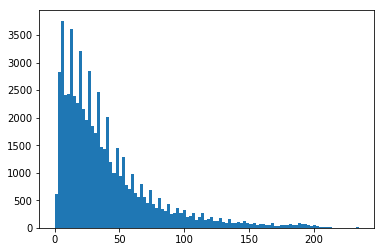

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=100);

Встановолюємо максимального вектору та вирівнюємо відносно цього розміру тренувальні і тестові данні.

In [105]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LEN = 235

train_padded_seqs = pad_sequences(train_sequences, maxlen = MAX_SEQ_LEN)
test_padded_seqs = pad_sequences(test_sequences, maxlen = MAX_SEQ_LEN)

print(train_padded_seqs.shape)
print(test_padded_seqs.shape)

(43287, 235)
(18552, 235)


Будуємо та тренуємо модель.

In [121]:
from keras.layers import LSTM, Embedding, Dense, Input, SpatialDropout1D, Dropout

class LstmModel(NnModel):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels,
                 embedding_dim, memory_units):
        super().__init__(train_vectors, 
                         train_labels, 
                         test_vectors, 
                         test_labels)
        self.model = Sequential()
        self.model.add(Embedding(MAX_WORDS_NUM, embedding_dim, input_length = MAX_SEQ_LEN))
        self.model.add(Dropout(0.2))        
        self.model.add(LSTM(memory_units, dropout=0.2, recurrent_dropout=0.2))        
        self.model.add(Dense(188, activation='softmax'))
        self.model.summary()
        self.model.compile(optimizer=RMSprop(lr=1e-3),
                           loss='categorical_crossentropy',
                           metrics=['acc'])        
    

In [122]:
lstm_model = LstmModel(train_padded_seqs, train_topic_labels, test_padded_seqs, test_topic_labels, 100, 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 235, 100)          4855300   
_________________________________________________________________
dropout_4 (Dropout)          (None, 235, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 188)               18988     
Total params: 4,954,688
Trainable params: 4,954,688
Non-trainable params: 0
_________________________________________________________________


In [123]:
lstm_model.train(30)

Train on 38952 samples, validate on 4328 samples
Epoch 1/30
38952/38952 [==============================] - 92s 2ms/step - loss: 4.1753 - acc: 0.1576 - val_loss: 3.7373 - val_acc: 0.2380
Epoch 2/30
38952/38952 [==============================] - 90s 2ms/step - loss: 3.3994 - acc: 0.2684 - val_loss: 3.0775 - val_acc: 0.3161
Epoch 3/30
38952/38952 [==============================] - 89s 2ms/step - loss: 2.9337 - acc: 0.3233 - val_loss: 2.7251 - val_acc: 0.3634
Epoch 4/30
38952/38952 [==============================] - 92s 2ms/step - loss: 2.5980 - acc: 0.3754 - val_loss: 2.4697 - val_acc: 0.4101
Epoch 5/30
38952/38952 [==============================] - 91s 2ms/step - loss: 2.3235 - acc: 0.4271 - val_loss: 2.2899 - val_acc: 0.4466
Epoch 6/30
38952/38952 [==============================] - 91s 2ms/step - loss: 2.0915 - acc: 0.4723 - val_loss: 2.1276 - val_acc: 0.4778
Epoch 7/30
38952/38952 [==============================] - 90s 2ms/step - loss: 1.8945 - acc: 0.5152 - val_loss: 2.0026 - val_acc:

In [129]:
lstm_model.test()

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       335
           1       0.69      0.59      0.63        41
           2       0.57      0.57      0.57        79
           3       0.34      0.46      0.39        39
           4       0.45      0.23      0.30        22
           5       0.70      0.72      0.71       106
           6       0.36      0.30      0.33       142
           7       0.67      0.61      0.64        62
           8       0.74      0.57      0.64        30
           9       0.63      0.55      0.59        22
          10       0.86      0.80      0.83       144
          11       0.28      0.17      0.21        29
          12       0.65      0.68      0.67        22
          13       0.46      0.40      0.43        45
          14       0.25      0.17      0.20        84
          15       0.64      0.56      0.60        16
          16       0.76      0.61      0.67       122
          17       0.50    

Якість приблизно така я у Logreg+Doc2Vec.

### CNN

Спробуємо застосувати згорточну мережу.

In [125]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

class CnnModel(NnModel):
     def __init__(self, train_vectors, train_labels, test_vectors, test_labels, 
                  embedding_dim, channels_num, conv_window):
        super().__init__(train_vectors, 
                         train_labels, 
                         test_vectors, 
                         test_labels)
        self.model = Sequential()
        self.model.add(Embedding(MAX_WORDS_NUM, embedding_dim, input_length = MAX_SEQ_LEN))
        self.model.add(Dropout(0.2))
        self.model.add(Conv1D(channels_num, conv_window, activation='relu'))
        self.model.add(MaxPooling1D(conv_window))
        self.model.add(Flatten())
        self.model.add(Dense(1024, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(188, activation='softmax'))
        self.model.summary()
        self.model.compile(optimizer=RMSprop(lr=1e-3),
                           loss='categorical_crossentropy',
                           metrics=['acc'])        
    

In [126]:
cnn_model = CnnModel(train_padded_seqs, train_topic_labels, test_padded_seqs, test_topic_labels, 100, 128, 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 235, 100)          4855300   
_________________________________________________________________
dropout_5 (Dropout)          (None, 235, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 231, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 46, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5888)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              6030336   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
__________

In [127]:
cnn_model.train(30)

Train on 38952 samples, validate on 4328 samples
Epoch 1/30
38952/38952 [==============================] - 69s 2ms/step - loss: 3.6320 - acc: 0.2328 - val_loss: 2.8530 - val_acc: 0.3415
Epoch 2/30
38952/38952 [==============================] - 69s 2ms/step - loss: 2.4023 - acc: 0.4127 - val_loss: 2.2241 - val_acc: 0.4630
Epoch 3/30
38952/38952 [==============================] - 68s 2ms/step - loss: 1.8068 - acc: 0.5257 - val_loss: 2.0443 - val_acc: 0.5072
Epoch 4/30
38952/38952 [==============================] - 69s 2ms/step - loss: 1.4328 - acc: 0.6060 - val_loss: 2.0490 - val_acc: 0.5206
Epoch 5/30
38952/38952 [==============================] - 68s 2ms/step - loss: 1.1630 - acc: 0.6743 - val_loss: 2.1007 - val_acc: 0.5354
Epoch 6/30
38952/38952 [==============================] - 68s 2ms/step - loss: 0.9518 - acc: 0.7299 - val_loss: 2.1749 - val_acc: 0.5566
Epoch 7/30
38952/38952 [==============================] - 68s 2ms/step - loss: 0.7770 - acc: 0.7795 - val_loss: 2.3155 - val_acc:

In [130]:
cnn_model.test()

              precision    recall  f1-score   support

           0       0.50      0.69      0.58       335
           1       0.59      0.56      0.57        41
           2       0.52      0.41      0.45        79
           3       0.39      0.36      0.37        39
           4       0.38      0.23      0.29        22
           5       0.55      0.61      0.58       106
           6       0.28      0.37      0.31       142
           7       0.33      0.61      0.43        62
           8       0.60      0.30      0.40        30
           9       0.50      0.36      0.42        22
          10       0.71      0.76      0.74       144
          11       0.25      0.14      0.18        29
          12       0.47      0.36      0.41        22
          13       0.37      0.53      0.44        45
          14       0.13      0.13      0.13        84
          15       0.35      0.56      0.43        16
          16       0.71      0.57      0.63       122
          17       0.25    

## Summary

In [134]:
from sklearn.metrics import accuracy_score

def accuracy(model):
    return accuracy_score(model.test_labels, model.topics_predicted)

def extract_metrics(model, group = 'macro avg'): 
    metrics = [line.strip() for line in  model.test_report.split('\n') if group in line][0]
    return [metric.strip() for metric in metrics[len(group)-1:].split()][1:-1]

pandas.DataFrame({
    'model': ['kNN+vectors sum',
              'logreg+vectors sum',
              'kNN+doc2vec',
              'logreg+doc2vec',
              'FNN+vectors sum',
              'FNN+doc2vec',
              'LSTM',
              'CNN'],
    'accuracy': [accuracy(knn),
                 accuracy(logreg),
                 accuracy(knn2),
                 accuracy(logreg2),
                 accuracy(ff_sum_model),
                 accuracy(ff_model),
                 accuracy(lstm_model),
                 accuracy(cnn_model)],
    'precision (macro avg)': [extract_metrics(knn)[0],
                              extract_metrics(logreg)[0],
                              extract_metrics(knn2)[0],
                              extract_metrics(logreg2)[0],
                              extract_metrics(ff_sum_model)[0],
                              extract_metrics(ff_model)[0],
                              extract_metrics(lstm_model)[0],
                              extract_metrics(cnn_model)[0]],
    'recall (macro avg)': [extract_metrics(knn)[1],
                              extract_metrics(logreg)[1],
                              extract_metrics(knn2)[1],
                              extract_metrics(logreg2)[1],
                              extract_metrics(ff_sum_model)[1],
                              extract_metrics(ff_model)[1],
                              extract_metrics(lstm_model)[1],
                              extract_metrics(cnn_model)[1]],
    'f1 (macro avg)': [extract_metrics(knn)[2],
                              extract_metrics(logreg)[2],
                              extract_metrics(knn2)[2],
                              extract_metrics(logreg2)[2],
                              extract_metrics(ff_sum_model)[2],
                              extract_metrics(ff_model)[2],
                              extract_metrics(lstm_model)[2],
                              extract_metrics(cnn_model)[2]]
})

,model,accuracy,precision (macro avg),recall (macro avg),f1 (macro avg)
0,kNN+vectors sum,0.460025,0.40,0.35,0.36
1,logreg+vectors sum,0.521106,0.42,0.42,0.41
2,kNN+doc2vec,0.592808,0.51,0.50,0.49
3,logreg+doc2vec,0.598954,0.58,0.47,0.50
4,FNN+vectors sum,0.557820,0.43,0.37,0.39
5,FNN+doc2vec,0.616260,0.60,0.49,0.52
6,LSTM,0.623699,0.50,0.46,0.47
7,CNN,0.531835,0.40,0.40,0.39


Бачимо що вдалося покращити якість у порівнянні з бейзлайном більш ніж на 10% згідно F1. Логістична регресія в порівнянні з kNN у всіх випадках працювала краще. Вектори документів також дали покращення у всіх випадках. Найкращий результат дало застосування feed forward мережі в комбінації с Doc2Vec, дуже близький результат дала LSTM мережа. Цікаво що аналогічні результати мают згорточна мереже і логістична мережа на сумі векторів. Виглядає так что згортка має той самий єфект що й сумма ембедінгів.